In [1]:
"""
DLF Assignment 3
Rui Pu a1679834
"""

'\nDLF Assignment 3\nRui Pu a1679834\n'

# About the Dataset

# Codes Start Here...

Import essential libraries

In [2]:
# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# NumPy & Pandas
import numpy as np
import pandas as pd
import math

# sklearn
import sklearn
import sklearn.preprocessing
from sklearn.metrics import mean_squared_error

# Plots
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)
mpl.rc('figure', dpi = 120)
plt.close('all')

# 1. Download and Pre-process Datasets

## 1.1. Load and preview the raw dataset

In [3]:
# load stock
df = pd.read_csv("GOOGL.csv")

# set Date as index
df.set_index("Date", inplace = True)
df.index =  pd.to_datetime(df.index, format='%Y/%m/%d')

# drop nan values
df.dropna(inplace = True)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4588 entries, 2004-08-19 to 2022-11-07
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4588 non-null   float64
 1   High       4588 non-null   float64
 2   Low        4588 non-null   float64
 3   Close      4588 non-null   float64
 4   Adj Close  4588 non-null   float64
 5   Volume     4588 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 250.9 KB
None


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,2.502503,2.604104,2.401401,2.511011,2.511011,893181924
2004-08-20,2.527778,2.729730,2.515015,2.710460,2.710460,456686856
2004-08-23,2.771522,2.839840,2.728979,2.737738,2.737738,365122512
2004-08-24,2.783784,2.792793,2.591842,2.624374,2.624374,304946748
2004-08-25,2.626627,2.702703,2.599600,2.652653,2.652653,183772044


Text(0, 0.5, 'Stock Price Action')

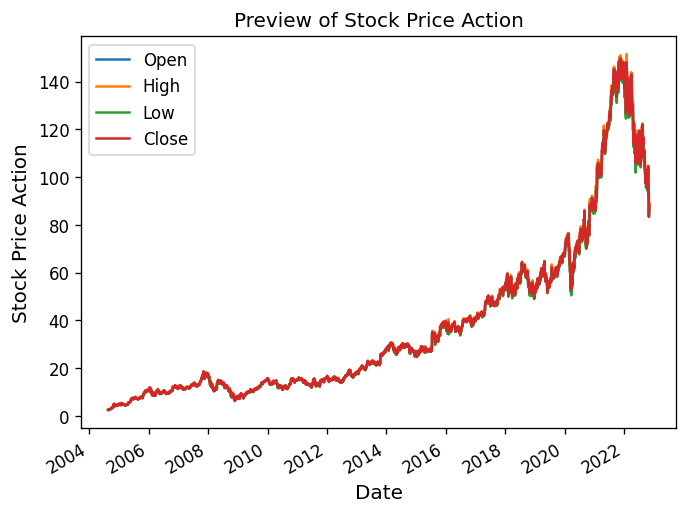

In [4]:
# Visualize stock action
df[['Open','High','Low','Close']].plot()
plt.title('Preview of Stock Price Action')
plt.xlabel('Date')
plt.ylabel('Stock Price Action')

## 1.2. Construct a pipeline FOR pre-processing and splitting data

In [5]:
def pipeline(df, col, seq_len):
    
    # min-max normalization of stock
    
    price = df[[col]].copy()
    scaler = sklearn.preprocessing.MinMaxScaler()
    price[col] = scaler.fit_transform(price[col].values.reshape(-1,1))
    
    # convert to numpy array
    data_raw = price.to_numpy() 
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    X_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    X_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return X_train, y_train, X_test, y_test, scaler

In [6]:
# Create train, test data

SEQ_LEN = 10 # choose sequence length
COL = 'Close'

X_train, y_train, X_test, y_test, SCALER = pipeline(df, COL, SEQ_LEN)
print('Shape of X_train :', X_train.shape)
print('Shape of y_train :', y_train.shape)
print('Shape of X_test  :', X_test.shape)
print('Shape of y_test  :', y_test.shape)

Shape of X_train : (3662, 9, 1)
Shape of y_train : (3662, 1)
Shape of X_test  : (916, 9, 1)
Shape of y_test  : (916, 1)


In [7]:
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

# 2. Define Networks, Training and Testing Methods

Networks include:

1. BASIC RNN
2. LSTM
3. GRU

## 2.1. RNN Architectures

In [8]:
class Network(nn.Module):
    
    """
    Define A RNN Generator.
    
    Parameters
    ----------
    input_size    : The number of expected features in the input x.
    hidden_size   : The number of features in the hidden state h.
    num_layers    : Default : 1.     Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two RNNs together to form a stacked RNN, with the second RNN taking in outputs of the first RNN and computing the final results. 
    bias          : Default : True.  If False, then the layer does not use bias weights b_ih and b_hh. 
    batch_first   : Default : False. If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Note that this does not apply to hidden or cell states. 
    dropout       : Default : 0.     If non-zero, introduces a Dropout layer on the outputs of each RNN layer except the last layer, with dropout probability equal to dropout. 
    bidirectional : Default : False. If True, becomes a bidirectional RNN. 
    proj_size     : Default : 0.     If > 0, will use LSTM with projections of corresponding size. 
    
    Attributes
    ----------
    Inputs  : input, (h_0, c_0)
        input  : (N, L, H_in) if batch_first is True.
        h_0    : (D∗num_layers, N, H_out). Defaults to zeros if not provided.
        c_0    : (D∗num_layers, N, H_cell). Defaults to zeros if not provided.
    Outputs : output, (h_n, c_n)
        output : (N, L, D∗H_out) if batch_first is True.
        h_n    : (D∗num_layers, N, H_out).
        c_n    : (D∗num_layers, N, H_cell).        
    where,
        N = batch size
        L = sequence length
        D = 1 if bidirectional is False otherwise 2
        H_in = input_size
        H_cell = hidden_size
        H_out = proj_size if proj_size > 0 otherwise hidden_size

    """
    
    def __init__(self, net, input_size, hidden_size, num_layers, output_size):
        
        super().__init__()
        self.net = net
        self.input_size = input_size   # input size
        self.hidden_size = hidden_size # hidden size
        self.num_layers = num_layers   # number of hidden layers
        self.output_size = output_size # expected output size
        
        # rnn layer: in: [batch_size, seq_len, input_size] --> out: [batch_size, seq_len, hidden_size]
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) 

        # lstm layer: in: [batch_size, seq_len, input_size] --> out: [batch_size, seq_len, hidden_size]
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) 
        
        # lstm layer: in: [batch_size, seq_len, input_size] --> out: [batch_size, seq_len, hidden_size]
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        
        # dropout layer
#         self.dropout = nn.Dropout(0.2)
        
        # fc layer: [x, x, hidden_size] --> [x, x, output_size]
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        
        if self.net == "RNN":
            out, h_n = self.rnn(x)             # in:[3657, 9, 1] --> out:[3657, 9, 64]; h_0:[1*1, 3657, 64] --> h_n:[1*1, 3657, 64]
        
        elif self.net == "LSTM":
            out, (h_n, c_n) = self.lstm(x)     # in:[3657, 9, 1] --> out:[3657, 9, 64]; h_0:[1*1, 3657, 64] --> h_n:[1*1, 3657, 64]
        
        elif self.net == "GRU":
            out, h_n = self.gru(x)             # in:[3657, 9, 1] --> out:[3657, 9, 64]; h_0:[1*1, 3657, 64] --> h_n:[1*1, 3657, 64]
        
        y_n = self.fc(out[:, -1, :])           # we just want last time step hidden states! [3657, 9, 64] --> [3657, 9, 1] --> [3657, 1]
        
        return y_n

## 2.2. Training Method

In [9]:
def train(model, criterion, opt, lr, epoches, print_loss=False, plot_loss=False):

    loss_history = []

    if opt == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif opt == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif opt == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
        
    print('Optimizer: {}, Learning rate: {}'.format(opt, lr))

        
    for e in range(1, epoches+1):

        # process: forward + backward + optimize
        y_train_pred = model(X_train)           # forward pass
        loss = criterion(y_train_pred, y_train) # compute loss
        
        optimizer.zero_grad()                   # zero out gradient, else they will accumulate between epochs
        loss.backward()                         # backward pass
        optimizer.step()                        # update parameters
        
        # save and print out loss 
        loss_history.append(loss.item())
        
        if print_loss: 
            if e % 10 == 0:
                print('Epoch: {}, MSE Loss: {:.5f}'.format(e, loss.item()))
    
    # Plot training loss against epoches
    if plot_loss:
        plt.plot(loss_history)
        plt.title("Training Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.show()

    return model, y_train_pred

## 2.3. Predict and Visualize Results

In [10]:
def predict_and_plot(model, modname, y_train_pred, y_train=y_train, y_test=y_test, scaler=SCALER, plot_prediction=False): 

    y_test_pred = model(X_test)
    
    # invert predictions
    y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
    y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
    y_train = scaler.inverse_transform(y_train)
    y_test = scaler.inverse_transform(y_test)
    
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    
    # Visualising the results
    if plot_prediction:
        figure, axes = plt.subplots(1, 2, figsize=(15, 5))

        axes[0].plot(df[COL], color = 'blue', label = 'Real Stock Price')
        axes[0].plot(df[:len(y_train)].index, y_train_pred, color = 'green', label = 'Predicted Train Stock Price')
        axes[0].plot(df[len(df)-len(y_test):].index, y_test_pred, color = 'red', label = 'Predicted Test Stock Price')
        axes[0].set_title('All Stock Price Prediction for {} model'.format(modname))

        axes[1].plot(df[len(df)-len(y_test):].index, y_test, color = 'blue', label = 'Real Test Stock Price')
        axes[1].plot(df[len(df)-len(y_test):].index, y_test_pred, color = 'red', label = 'Predicted Test Stock Price')
        axes[1].set_title('Test Stock Price Prediction for {} model'.format(modname))

        for ax in axes.flat:
            ax.set(xlabel='Time', ylabel='Stock Price')
            ax.xaxis_date()
            ax.legend()

        plt.show()

# 3. Experiments: Train and Test on Different Architectures

Define a function to run different layers.

In [11]:
def run_different_layers(m, num_layers, hidden_size):
    
    # Note: all CAPITALs are GLOBAL parameters
    
    # generate model
    model = Network(m, INPUT_SIZE, hidden_size, num_layers, OUTPUT_SIZE)
    print(f'Running in {m} model with')
    print(f'{num_layers} hidden layers, {hidden_size} hidden features.')

    # train the model
    (trained_model, y_train_pred) = train(model, LOSS, OPT, LR, NUM_EPOCH)
    
    # predict the model
    predict_and_plot(trained_model, m, y_train_pred)
    print('----------------------------------------')

Define a general loss function and a general optimzer for all models.

In [12]:
# compute MSE (not classification problem)
LOSS = nn.MSELoss()

# optimizer: Adam (lr=0.01)
OPT = "Adam"
LR = 0.01

Define some common values for all models regarding the layers.

In [13]:
INPUT_SIZE = 1   # input size
OUTPUT_SIZE = 1  # expected output size
NUM_EPOCH = 100  # number of epoches

Define cases to be explored.

In [14]:
MODEL = ["RNN", "LSTM", "GRU"]  # model architechtures
NUM_LAYERS = [1, 2]             # number of hidden layers
HIDDEN_SIZE = [8, 16, 32, 64]   # hidden size

## 3.1. RNN

In [15]:
for n_layer in NUM_LAYERS:
    for h_size in HIDDEN_SIZE:
        run_different_layers(MODEL[0], n_layer, h_size)

Running in RNN model with
1 hidden layers, 8 hidden features.
Optimizer: Adam, Learning rate: 0.01
Train Score: 0.45 RMSE
Test Score: 7.43 RMSE
----------------------------------------
Running in RNN model with
1 hidden layers, 16 hidden features.
Optimizer: Adam, Learning rate: 0.01
Train Score: 0.48 RMSE
Test Score: 6.53 RMSE
----------------------------------------
Running in RNN model with
1 hidden layers, 32 hidden features.
Optimizer: Adam, Learning rate: 0.01
Train Score: 0.50 RMSE
Test Score: 5.49 RMSE
----------------------------------------
Running in RNN model with
1 hidden layers, 64 hidden features.
Optimizer: Adam, Learning rate: 0.01
Train Score: 0.68 RMSE
Test Score: 15.09 RMSE
----------------------------------------
Running in RNN model with
2 hidden layers, 8 hidden features.
Optimizer: Adam, Learning rate: 0.01
Train Score: 1.46 RMSE
Test Score: 30.90 RMSE
----------------------------------------
Running in RNN model with
2 hidden layers, 16 hidden features.
Optimiz

## 3.2. LSTM

In [16]:
for n_layer in NUM_LAYERS:
    for h_size in HIDDEN_SIZE:
        run_different_layers(MODEL[1], n_layer, h_size)

Running in LSTM model with
1 hidden layers, 8 hidden features.
Optimizer: Adam, Learning rate: 0.01
Train Score: 2.40 RMSE
Test Score: 14.15 RMSE
----------------------------------------
Running in LSTM model with
1 hidden layers, 16 hidden features.
Optimizer: Adam, Learning rate: 0.01
Train Score: 0.67 RMSE
Test Score: 15.96 RMSE
----------------------------------------
Running in LSTM model with
1 hidden layers, 32 hidden features.
Optimizer: Adam, Learning rate: 0.01
Train Score: 0.96 RMSE
Test Score: 5.96 RMSE
----------------------------------------
Running in LSTM model with
1 hidden layers, 64 hidden features.
Optimizer: Adam, Learning rate: 0.01
Train Score: 0.64 RMSE
Test Score: 4.20 RMSE
----------------------------------------
Running in LSTM model with
2 hidden layers, 8 hidden features.
Optimizer: Adam, Learning rate: 0.01
Train Score: 1.62 RMSE
Test Score: 40.63 RMSE
----------------------------------------
Running in LSTM model with
2 hidden layers, 16 hidden features.


## 3.3. GRU

In [17]:
for n_layer in NUM_LAYERS:
    for h_size in HIDDEN_SIZE:
        run_different_layers(MODEL[2], n_layer, h_size)

Running in GRU model with
1 hidden layers, 8 hidden features.
Optimizer: Adam, Learning rate: 0.01
Train Score: 0.54 RMSE
Test Score: 4.49 RMSE
----------------------------------------
Running in GRU model with
1 hidden layers, 16 hidden features.
Optimizer: Adam, Learning rate: 0.01
Train Score: 0.61 RMSE
Test Score: 9.24 RMSE
----------------------------------------
Running in GRU model with
1 hidden layers, 32 hidden features.
Optimizer: Adam, Learning rate: 0.01
Train Score: 0.56 RMSE
Test Score: 4.87 RMSE
----------------------------------------
Running in GRU model with
1 hidden layers, 64 hidden features.
Optimizer: Adam, Learning rate: 0.01
Train Score: 0.57 RMSE
Test Score: 4.86 RMSE
----------------------------------------
Running in GRU model with
2 hidden layers, 8 hidden features.
Optimizer: Adam, Learning rate: 0.01
Train Score: 0.74 RMSE
Test Score: 18.86 RMSE
----------------------------------------
Running in GRU model with
2 hidden layers, 16 hidden features.
Optimize

## 3.4. Comments on Different Architectures

# 4. Experiments: Train and Test on Different Optimizers and Learning Rates

Define a function to run different optimizers and learning rates.

In [18]:
def run_different_optimizers(m, hidden_size, opt, lr):
    
    # Note: all CAPITALs are GLOBAL parameters
    
    # generate model
    model = Network(m, INPUT_SIZE, hidden_size, 1, OUTPUT_SIZE)
    print(f'Running in {m} model with')
    print(f'{1} hidden layers, {hidden_size} hidden features.')

    # train the model
    (trained_model, y_train_pred) = train(model, LOSS, opt, lr, NUM_EPOCH)

    # predict the model
    predict_and_plot(trained_model, m, y_train_pred)
    print('----------------------------------------')

Define cases to be explored.

In [19]:
OPTIMIZER = ["SGD", "Adam", "RMSprop"]
LEARNING_RATE = [0.001, 0.005, 0.01, 0.05, 0.1]

## 4.1. RNN

In [20]:
for opt in OPTIMIZER:
    for lr in LEARNING_RATE:
        for h_size in HIDDEN_SIZE: 
            run_different_optimizers(MODEL[0], h_size, opt, lr)

Running in RNN model with
1 hidden layers, 8 hidden features.
Optimizer: SGD, Learning rate: 0.001
Train Score: 17.18 RMSE
Test Score: 87.44 RMSE
----------------------------------------
Running in RNN model with
1 hidden layers, 16 hidden features.
Optimizer: SGD, Learning rate: 0.001
Train Score: 17.28 RMSE
Test Score: 88.45 RMSE
----------------------------------------
Running in RNN model with
1 hidden layers, 32 hidden features.
Optimizer: SGD, Learning rate: 0.001
Train Score: 15.22 RMSE
Test Score: 78.16 RMSE
----------------------------------------
Running in RNN model with
1 hidden layers, 64 hidden features.
Optimizer: SGD, Learning rate: 0.001
Train Score: 15.52 RMSE
Test Score: 79.37 RMSE
----------------------------------------
Running in RNN model with
1 hidden layers, 8 hidden features.
Optimizer: SGD, Learning rate: 0.005
Train Score: 13.38 RMSE
Test Score: 68.08 RMSE
----------------------------------------
Running in RNN model with
1 hidden layers, 16 hidden features.

Train Score: 0.62 RMSE
Test Score: 15.94 RMSE
----------------------------------------
Running in RNN model with
1 hidden layers, 16 hidden features.
Optimizer: RMSprop, Learning rate: 0.005
Train Score: 1.98 RMSE
Test Score: 27.59 RMSE
----------------------------------------
Running in RNN model with
1 hidden layers, 32 hidden features.
Optimizer: RMSprop, Learning rate: 0.005
Train Score: 4.25 RMSE
Test Score: 32.27 RMSE
----------------------------------------
Running in RNN model with
1 hidden layers, 64 hidden features.
Optimizer: RMSprop, Learning rate: 0.005
Train Score: 24.99 RMSE
Test Score: 54.18 RMSE
----------------------------------------
Running in RNN model with
1 hidden layers, 8 hidden features.
Optimizer: RMSprop, Learning rate: 0.01
Train Score: 0.67 RMSE
Test Score: 21.77 RMSE
----------------------------------------
Running in RNN model with
1 hidden layers, 16 hidden features.
Optimizer: RMSprop, Learning rate: 0.01
Train Score: 2.48 RMSE
Test Score: 29.73 RMSE
-

## 4.2. LSTM

In [21]:
for opt in OPTIMIZER:
    for lr in LEARNING_RATE:
        for h_size in HIDDEN_SIZE: 
            run_different_optimizers(MODEL[1], h_size, opt, lr)

Running in LSTM model with
1 hidden layers, 8 hidden features.
Optimizer: SGD, Learning rate: 0.001
Train Score: 15.79 RMSE
Test Score: 81.17 RMSE
----------------------------------------
Running in LSTM model with
1 hidden layers, 16 hidden features.
Optimizer: SGD, Learning rate: 0.001
Train Score: 15.44 RMSE
Test Score: 79.91 RMSE
----------------------------------------
Running in LSTM model with
1 hidden layers, 32 hidden features.
Optimizer: SGD, Learning rate: 0.001
Train Score: 15.14 RMSE
Test Score: 77.81 RMSE
----------------------------------------
Running in LSTM model with
1 hidden layers, 64 hidden features.
Optimizer: SGD, Learning rate: 0.001
Train Score: 15.45 RMSE
Test Score: 79.27 RMSE
----------------------------------------
Running in LSTM model with
1 hidden layers, 8 hidden features.
Optimizer: SGD, Learning rate: 0.005
Train Score: 14.42 RMSE
Test Score: 72.26 RMSE
----------------------------------------
Running in LSTM model with
1 hidden layers, 16 hidden fea

Train Score: 0.98 RMSE
Test Score: 4.29 RMSE
----------------------------------------
Running in LSTM model with
1 hidden layers, 8 hidden features.
Optimizer: RMSprop, Learning rate: 0.005
Train Score: 3.03 RMSE
Test Score: 9.82 RMSE
----------------------------------------
Running in LSTM model with
1 hidden layers, 16 hidden features.
Optimizer: RMSprop, Learning rate: 0.005
Train Score: 0.69 RMSE
Test Score: 5.39 RMSE
----------------------------------------
Running in LSTM model with
1 hidden layers, 32 hidden features.
Optimizer: RMSprop, Learning rate: 0.005
Train Score: 2.75 RMSE
Test Score: 34.93 RMSE
----------------------------------------
Running in LSTM model with
1 hidden layers, 64 hidden features.
Optimizer: RMSprop, Learning rate: 0.005
Train Score: 1.59 RMSE
Test Score: 42.79 RMSE
----------------------------------------
Running in LSTM model with
1 hidden layers, 8 hidden features.
Optimizer: RMSprop, Learning rate: 0.01
Train Score: 6.82 RMSE
Test Score: 25.43 RMSE


## 4.3. GRU

In [22]:
for opt in OPTIMIZER:
    for lr in LEARNING_RATE:
        for h_size in HIDDEN_SIZE: 
            run_different_optimizers(MODEL[2], h_size, opt, lr)

Running in GRU model with
1 hidden layers, 8 hidden features.
Optimizer: SGD, Learning rate: 0.001
Train Score: 15.87 RMSE
Test Score: 81.29 RMSE
----------------------------------------
Running in GRU model with
1 hidden layers, 16 hidden features.
Optimizer: SGD, Learning rate: 0.001
Train Score: 14.55 RMSE
Test Score: 74.41 RMSE
----------------------------------------
Running in GRU model with
1 hidden layers, 32 hidden features.
Optimizer: SGD, Learning rate: 0.001
Train Score: 16.28 RMSE
Test Score: 82.91 RMSE
----------------------------------------
Running in GRU model with
1 hidden layers, 64 hidden features.
Optimizer: SGD, Learning rate: 0.001
Train Score: 15.00 RMSE
Test Score: 76.33 RMSE
----------------------------------------
Running in GRU model with
1 hidden layers, 8 hidden features.
Optimizer: SGD, Learning rate: 0.005
Train Score: 12.23 RMSE
Test Score: 62.58 RMSE
----------------------------------------
Running in GRU model with
1 hidden layers, 16 hidden features.

Train Score: 3.38 RMSE
Test Score: 10.95 RMSE
----------------------------------------
Running in GRU model with
1 hidden layers, 16 hidden features.
Optimizer: RMSprop, Learning rate: 0.005
Train Score: 8.81 RMSE
Test Score: 21.83 RMSE
----------------------------------------
Running in GRU model with
1 hidden layers, 32 hidden features.
Optimizer: RMSprop, Learning rate: 0.005
Train Score: 0.63 RMSE
Test Score: 10.57 RMSE
----------------------------------------
Running in GRU model with
1 hidden layers, 64 hidden features.
Optimizer: RMSprop, Learning rate: 0.005
Train Score: 3.09 RMSE
Test Score: 13.97 RMSE
----------------------------------------
Running in GRU model with
1 hidden layers, 8 hidden features.
Optimizer: RMSprop, Learning rate: 0.01
Train Score: 3.05 RMSE
Test Score: 22.09 RMSE
----------------------------------------
Running in GRU model with
1 hidden layers, 16 hidden features.
Optimizer: RMSprop, Learning rate: 0.01
Train Score: 2.63 RMSE
Test Score: 12.54 RMSE
--

## 4.4. Comments on Different Optimizers and Learning Rates

# 5. Best Model

In [23]:
# tuned hyperparameters
m = "GRU"
hidden_size = 32
num_layers = 1
opt = "Adam"
lr = 0.01

Running in GRU model with
1 hidden layers, 32 hidden features.
Optimizer: Adam, Learning rate: 0.01
Epoch: 10, MSE Loss: 0.00881
Epoch: 20, MSE Loss: 0.00588
Epoch: 30, MSE Loss: 0.00138
Epoch: 40, MSE Loss: 0.00031
Epoch: 50, MSE Loss: 0.00002
Epoch: 60, MSE Loss: 0.00008
Epoch: 70, MSE Loss: 0.00002
Epoch: 80, MSE Loss: 0.00002
Epoch: 90, MSE Loss: 0.00002
Epoch: 100, MSE Loss: 0.00001


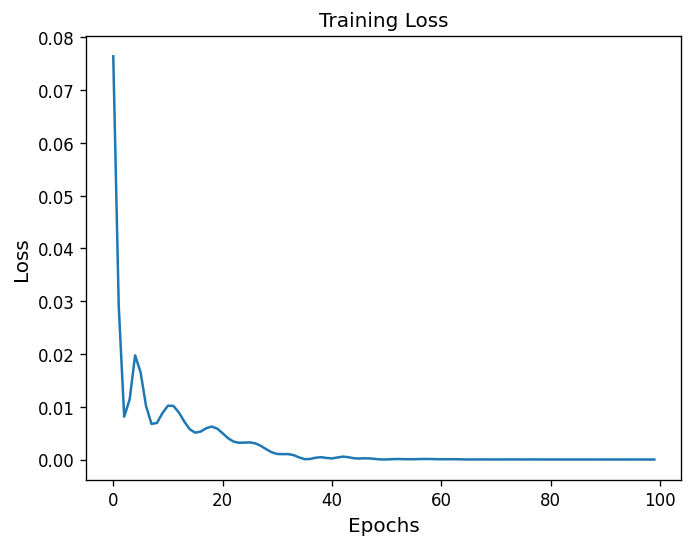

In [24]:
# generate model
best_model = Network(m, INPUT_SIZE, hidden_size, num_layers, OUTPUT_SIZE)
print(f'Running in {m} model with')
print(f'{num_layers} hidden layers, {hidden_size} hidden features.')

# train the model
(trained_best_model, y_train_pred) = train(best_model, LOSS, opt, lr, NUM_EPOCH,
                                           print_loss=True, plot_loss=True)

Train Score: 0.54 RMSE
Test Score: 5.67 RMSE


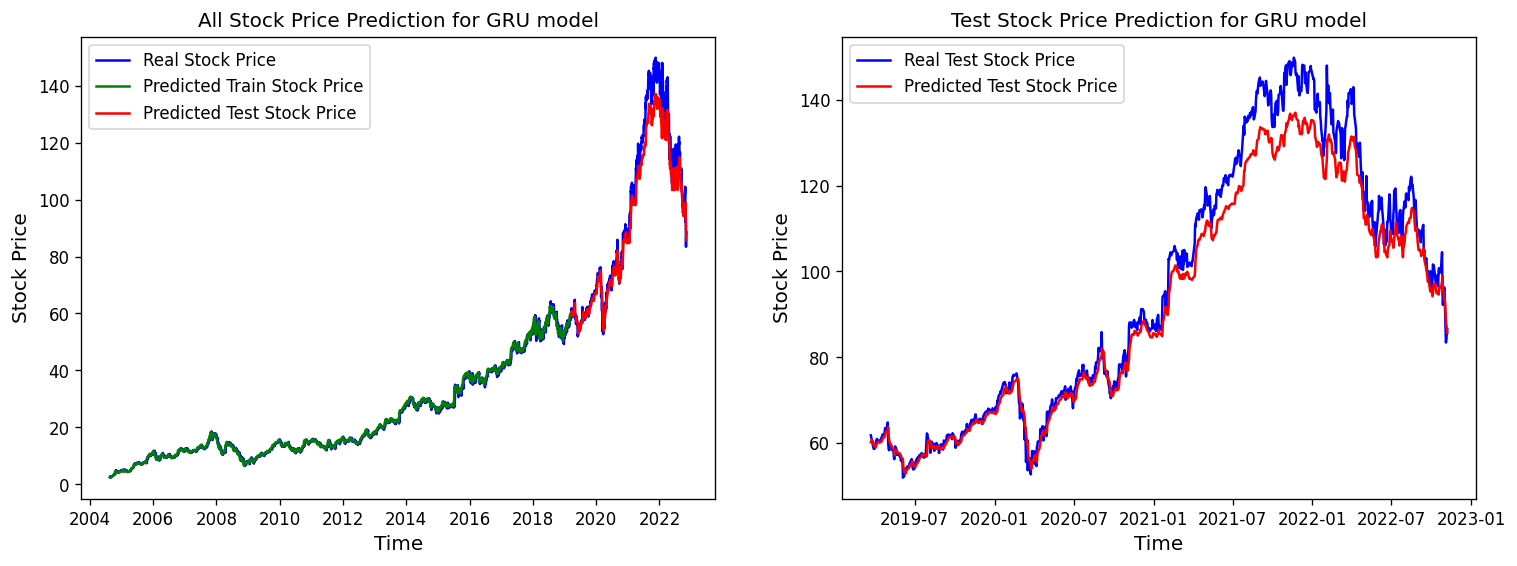

In [25]:
# predict the model
predict_and_plot(trained_best_model, m, y_train_pred, plot_prediction=True)